In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin

# --- Modelos Estándar de Sklearn ---
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KernelDensity, NearestNeighbors
from ucimlrepo import fetch_ucirepo



In [3]:
# =============================================================================
# UTILIDADES: CÁLCULO DE MEAN IR Y BALANCEO
# =============================================================================

def compute_mean_ir(y):
    """
    Calcula el Mean Imbalance Ratio según la fórmula del PDF.
    """
    counts = Counter(y)
    max_count = max(counts.values())
    n_classes = len(counts)
    
    sum_ir = 0
    classes = list(counts.keys())
    
    for i in classes:
        sum_ir += max_count / counts[i]
        
    return sum_ir / n_classes

def adjust_dataset_ir(X, y, target_threshold=1.15, mode='balance'):
    """
    Ajusta el dataset eliminando muestras para cumplir el umbral de MeanIR.
    mode 'balance': Busca MeanIR < 1.15 (elimina de la clase mayoritaria).
    mode 'imbalance': Busca MeanIR > 1.15 (elimina de clases aleatorias/minoritarias).
    """
    X_curr, y_curr = X.copy(), y.copy()
    rng = np.random.default_rng(42)
    
    # Límite de iteraciones para evitar bucles infinitos
    max_iter = 5000
    iter_count = 0
    
    while iter_count < max_iter:
        current_ir = compute_mean_ir(y_curr)
        counts = Counter(y_curr)
        
        # Condición de parada
        if mode == 'balance':
            if current_ir < target_threshold: break
            class_to_reduce = max(counts, key=counts.get)
            
        else: 
            if current_ir > target_threshold: break
            majority_class = max(counts, key=counts.get)
            candidates = [c for c in counts.keys() if c != majority_class and counts[c] > 5]
            if not candidates: break # No podemos desbalancear más sin vaciar clases
            class_to_reduce = rng.choice(candidates)

        # Encontrar índices de esa clase y eliminar uno al azar
        indices = np.where(y_curr == class_to_reduce)[0]
        idx_to_remove = rng.choice(indices)
        
        X_curr = np.delete(X_curr, idx_to_remove, axis=0)
        y_curr = np.delete(y_curr, idx_to_remove)
        iter_count += 1

    print(f"({mode}): MeanIR final = {compute_mean_ir(y_curr):.4f} | Muestras: {len(y_curr)}")
    return X_curr, y_curr

In [4]:
# =============================================================================
# CLASIFICADORES PERSONALIZADOS
# =============================================================================

class NaiveHistogramClassifier(BaseEstimator, ClassifierMixin):
    """
    Estimador de densidad por Histograma (Multivariante asumiendo independencia).
    """
    def __init__(self, bins=10):
        self.bins = bins

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.priors_ = {}
        self.hists_ = {}
        self.edges_ = {}
        self.n_features_ = X.shape[1]
        
        for f in range(self.n_features_):
            self.edges_[f] = np.linspace(X[:, f].min(), X[:, f].max(), self.bins + 1)

        for c in self.classes_:
            X_c = X[y == c]
            self.priors_[c] = len(X_c) / len(X)
            self.hists_[c] = []
            
            for f in range(self.n_features_):
                h, _ = np.histogram(X_c[:, f], bins=self.edges_[f], density=True)
                h = np.maximum(h, 1e-7)
                self.hists_[c].append(h)
        return self

    def predict_proba(self, X):
        probs = []
        for x in X:
            class_probs = []
            for c in self.classes_:
                likelihood = 1.0
                for f in range(self.n_features_):
                    # Encontrar bin
                    bin_idx = np.digitize(x[f], self.edges_[f]) - 1
                    bin_idx = np.clip(bin_idx, 0, self.bins - 1)
                    likelihood *= self.hists_[c][f][bin_idx]
                
                class_probs.append(likelihood * self.priors_[c])
            probs.append(class_probs)
        
        probs = np.array(probs)
        return probs / probs.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class ParzenWindowClassifier(BaseEstimator, ClassifierMixin):
    """
    Clasificador basado en Ventana de Parzen (Multivariante usando KernelDensity).
    """
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = {}
        self.priors_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.priors_[c] = len(X_c) / len(X)
            self.models_[c] = KernelDensity(kernel='gaussian', bandwidth=self.bandwidth).fit(X_c)
        return self

    def predict(self, X):
        log_probs = []
        for c in self.classes_:
            log_likelihood = self.models_[c].score_samples(X)
            log_posterior = log_likelihood + np.log(self.priors_[c])
            log_probs.append(log_posterior)
        
        log_probs = np.array(log_probs).T
        return self.classes_[np.argmax(log_probs, axis=1)]

class KnnDensityClassifier(BaseEstimator, ClassifierMixin):
    """
    Clasificador basado en densidad k_n Nearest Neighbor.
    P(x|c) ~ k / (N_c * V_k), donde V_k es el volumen hasta el k-vecino.
    """
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = {}
        self.counts_ = {}
        self.total_N_ = len(X)
        
        for c in self.classes_:
            X_c = X[y == c]
            self.counts_[c] = len(X_c)
            k_safe = min(self.n_neighbors, len(X_c))
            self.models_[c] = NearestNeighbors(n_neighbors=k_safe).fit(X_c)
        return self

    def predict(self, X):
        class_scores = np.zeros((X.shape[0], len(self.classes_)))
        epsilon = 1e-10
        for i, c in enumerate(self.classes_):
            k_safe = min(self.n_neighbors, self.counts_[c])
            dists, _ = self.models_[c].kneighbors(X, n_neighbors=k_safe)
            d_k = dists[:, -1] 
            score = (self.counts_[c] / self.total_N_) / (d_k + epsilon)
            class_scores[:, i] = score
        return self.classes_[np.argmax(class_scores, axis=1)]

In [5]:
try:
    dataset = fetch_ucirepo(id=212)
    X_raw = dataset.data.features.values
    y_raw = LabelEncoder().fit_transform(dataset.data.targets.values.ravel())

    # Normalización (Crucial para KNN y Parzen)
    scaler = StandardScaler()
    X_raw = scaler.fit_transform(X_raw)

    print(f"Dataset cargado: {X_raw.shape} muestras.")
    print(f"MeanIR Original: {compute_mean_ir(y_raw):.4f}")
except Exception as e:
    print(f"Error al cargar dataset: {e}")

Dataset cargado: (310, 6) muestras.
MeanIR Original: 1.6667


In [6]:
X_bal, y_bal = adjust_dataset_ir(X_raw, y_raw, 1.15, 'balance')
X_imb, y_imb = adjust_dataset_ir(X_raw, y_raw, 1.15, 'imbalance')

assortments = {
    "Balanced (MeanIR < 1.15)": (X_bal, y_bal),
    "Imbalanced (MeanIR > 1.15)": (X_imb, y_imb)
}

(balance): MeanIR final = 1.1444 | Muestras: 232
(imbalance): MeanIR final = 1.6667 | Muestras: 310


In [7]:
mod_config = {
    'MLE (QDA)': (QuadraticDiscriminantAnalysis(), {'reg_param': [0.0, 0.1, 0.5]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-5]}),
    'Histogram Est.': (NaiveHistogramClassifier(), {'bins': [5, 10, 20]}),
    'Parzen Window': (ParzenWindowClassifier(), {'bandwidth': [0.1, 0.5, 1.0, 2.0]}),
    'kn-NN (Density)': (KnnDensityClassifier(), {'n_neighbors': [3, 5, 9, 15]}),
    'k-NN (Rule)': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 9, 15]})
}


In [8]:
resultados = []
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for dataset_name, (X_data, y_data) in assortments.items():
    
    for model_name, (model, params) in mod_config.items():
        fold_accuracies = []
        
        for train_idx, test_idx in outer_cv.split(X_data, y_data):
            X_train_full, X_test = X_data[train_idx], X_data[test_idx]
            y_train_full, y_test = y_data[train_idx], y_data[test_idx]
            
            # Inner CV para optimizar hiperparámetros
            clf = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
            clf.fit(X_train_full, y_train_full)
            
            best_model = clf.best_estimator_
            y_pred = best_model.predict(X_test)
            fold_accuracies.append(accuracy_score(y_test, y_pred))
            
        resultados.append({
            "Assortment": dataset_name,
            "Method": model_name,
            "Accuracy Mean": np.mean(fold_accuracies),
            "Accuracy Std": np.std(fold_accuracies),
            "Best Params": clf.best_params_
        })



c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\

In [20]:
df_res = pd.DataFrame(resultados)
df_res = df_res.sort_values(by=['Assortment', 'Accuracy Mean'], ascending=[True, False])

print("RESUMEN:")
display(df_res[['Assortment', 'Method', 'Accuracy Mean', 'Accuracy Std']])

RESUMEN:


,Assortment,Method,Accuracy Mean,Accuracy Std
1,Balanced (MeanIR < 1.15),Naive Bayes,0.797502,0.028609
0,Balanced (MeanIR < 1.15),MLE (QDA),0.793340,0.033496
3,Balanced (MeanIR < 1.15),Parzen Window,0.741166,0.060650
5,Balanced (MeanIR < 1.15),k-NN (Rule),0.711008,0.033987
2,Balanced (MeanIR < 1.15),Histogram Est.,0.707123,0.049046
4,Balanced (MeanIR < 1.15),kn-NN (Density),0.638020,0.030594
6,Imbalanced (MeanIR > 1.15),MLE (QDA),0.848387,0.051613
7,Imbalanced (MeanIR > 1.15),Naive Bayes,0.835484,0.044930
9,Imbalanced (MeanIR > 1.15),Parzen Window,0.793548,0.018810
11,Imbalanced (MeanIR > 1.15),k-NN (Rule),0.783871,0.029915


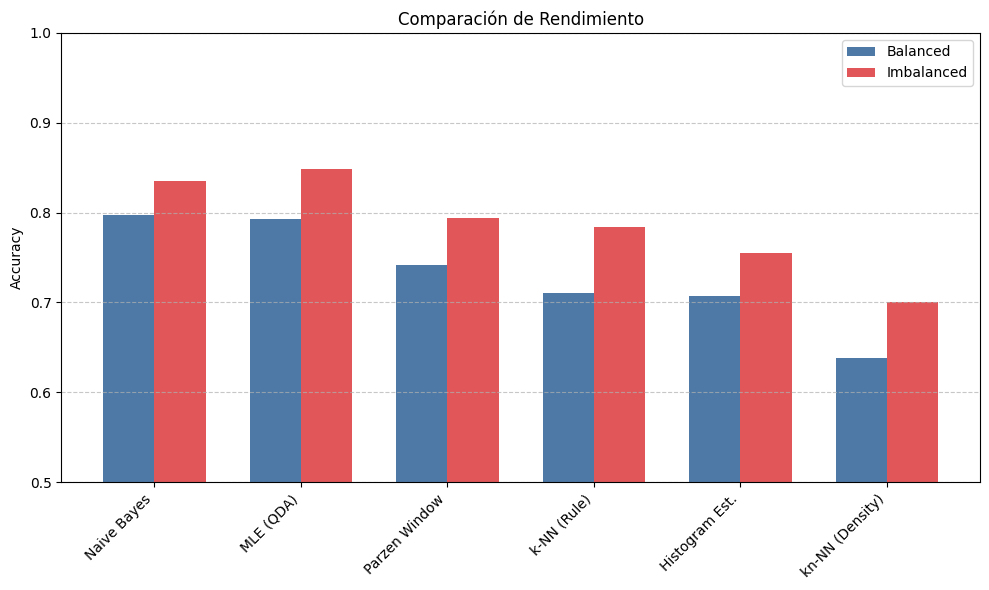

In [19]:
methods = df_res['Method'].unique()
bal_data = df_res[df_res['Assortment'].str.contains('Balanced')].set_index('Method')['Accuracy Mean']
imb_data = df_res[df_res['Assortment'].str.contains('Imbalanced')].set_index('Method')['Accuracy Mean']

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [bal_data[m] for m in methods], width, label='Balanced', color='#4e79a7')
rects2 = ax.bar(x + width/2, [imb_data[m] for m in methods], width, label='Imbalanced', color='#e15759')

ax.set_ylabel('Accuracy')
ax.set_title('Comparación de Rendimiento')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Generando visualización de fronteras (Proyección PCA)...


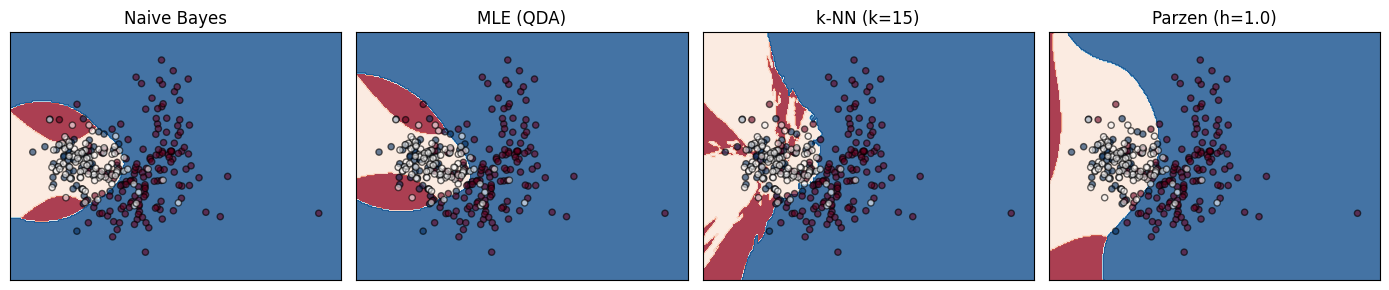

Observación: Nota cómo MLE genera regiones suaves y elípticas, mientras que k-NN fragmenta el espacio.


In [18]:
# --- BONUS: Visualización de Fronteras de Decisión (PCA 2D) ---
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

print("Generando visualización de fronteras (Proyección PCA)...")

# 1. Reducir a 2D para visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_raw) # Usamos el dataset completo original normalizado

# 2. Definir modelos para visualizar (Usamos parámetros fijos razonables)
classifiers = {
    "Naive Bayes": GaussianNB(),
    "MLE (QDA)": QuadraticDiscriminantAnalysis(),
    "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15),
    "Parzen (h=1.0)": ParzenWindowClassifier(bandwidth=1.0)
}

# 3. Configurar Malla
h = .05  # Paso de la malla
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 4. Plotear
figure = plt.figure(figsize=(14, 3))
i = 1

for name, clf in classifiers.items():
    ax = plt.subplot(1, 4, i)
    
    # Entrenar en el espacio reducido 2D (solo para la foto)
    clf.fit(X_pca, y_raw)
    
    # Predecir en la malla
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Convertir a color
    if len(Z.shape) > 1: Z = np.argmax(Z, axis=1) # Si devuelve probas
    Z = Z.reshape(xx.shape)
    
    # Pintar contornos
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
    
    # Pintar puntos de datos
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_raw, cmap=plt.cm.RdBu_r,
               edgecolors='k', s=20, alpha=0.6)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    i += 1

plt.tight_layout()
plt.show()
print("Observación: Nota cómo MLE genera regiones suaves y elípticas, mientras que k-NN fragmenta el espacio.")

Generada: comparison_plot.png
Generada: decision_boundaries.png


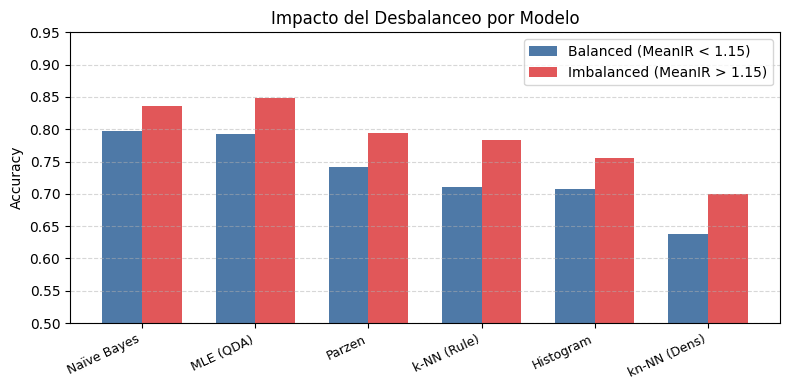

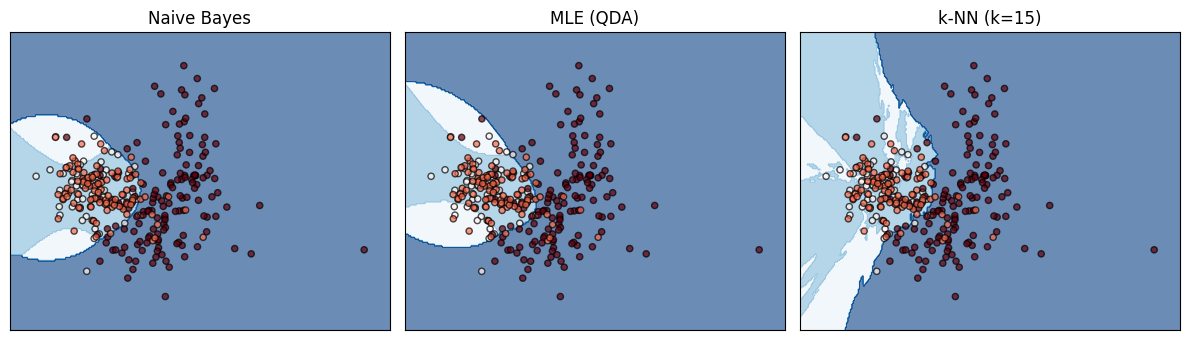

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# --- IMAGEN 1: Gráfico de Barras (Comparativa) ---
labels = ['Naïve Bayes', 'MLE (QDA)', 'Parzen', 'k-NN (Rule)', 'Histogram', 'kn-NN (Dens)']
balanced = [0.798, 0.793, 0.741, 0.711, 0.707, 0.638]
imbalanced = [0.836, 0.848, 0.794, 0.784, 0.755, 0.700]

x = np.arange(len(labels))
width = 0.35

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(x - width/2, balanced, width, label='Balanced (MeanIR < 1.15)', color='#4e79a7')
ax1.bar(x + width/2, imbalanced, width, label='Imbalanced (MeanIR > 1.15)', color='#e15759')
ax1.set_ylabel('Accuracy')
ax1.set_title('Impacto del Desbalanceo por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=25, ha="right", fontsize=9)
ax1.legend()
ax1.set_ylim(0.5, 0.95)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300) # <--- GUARDAR
print("Generada: comparison_plot.png")

# --- IMAGEN 2: Fronteras de Decisión (PCA) ---
# Usamos X_raw e y_raw de tu código anterior
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_raw) 

classifiers = {
    "Naive Bayes": GaussianNB(),
    "MLE (QDA)": QuadraticDiscriminantAnalysis(),
    "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15)
}

fig2 = plt.figure(figsize=(12, 3.5))
h = .05
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

i = 1
for name, clf in classifiers.items():
    ax = plt.subplot(1, 3, i)
    clf.fit(X_pca, y_raw)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.6)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_raw, cmap=plt.cm.Reds, edgecolors='k', s=20, alpha=0.7)
    ax.set_title(name)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

plt.tight_layout()
plt.savefig('decision_boundaries.png', dpi=300) # <--- GUARDAR
print("Generada: decision_boundaries.png")

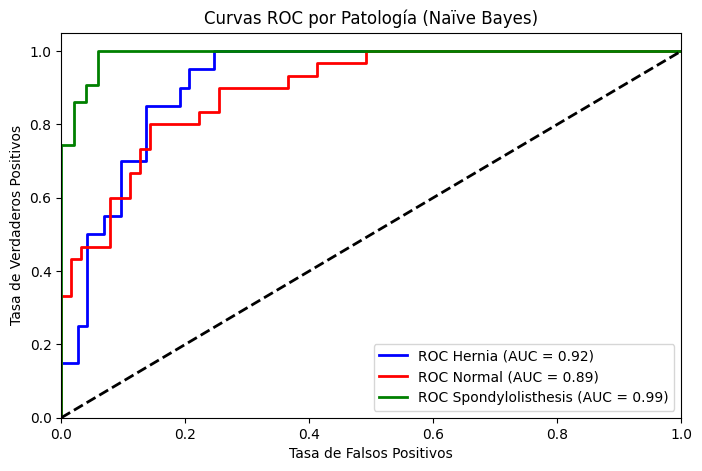

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- BONUS: Curva ROC Multiclase ---

# Binarizar etiquetas para ROC multiclase
y_bin = label_binarize(y_raw, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Entrenar un modelo simple para el ejemplo
classifier = GaussianNB()
y_score = classifier.fit(X_train_full, y_train_full).predict_proba(X_test)
# Nota: X_train/test deben ser del split anterior, si da error, haz un split rápido aquí
X_tr, X_te, y_tr, y_te = train_test_split(X_raw, y_bin, test_size=0.3, random_state=0)
y_score = classifier.fit(X_tr, np.argmax(y_tr, axis=1)).predict_proba(X_te)

# Calcular ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear
plt.figure(figsize=(8, 5))
colors = ['blue', 'red', 'green']
clases_nombres = ['Hernia', 'Normal', 'Spondylolisthesis'] # Nombres reales

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC {0} (AUC = {1:0.2f})'.format(clases_nombres[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Patología (Naïve Bayes)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [22]:
# --- CÓDIGO PYTHON ACTUALIZADO (Añadir al final de tu Notebook) ---
from sklearn.metrics import f1_score

# Recalculamos métricas incluyendo F1-Macro
print("Calculando F1-Macro Score...")
results_extended = []

for dataset_name, (X_data, y_data) in assortments.items():
    print(f"Procesando {dataset_name}...")
    for model_name, (model, params) in mod_config.items():
        f1_scores = []
        # Usamos el mismo outer_cv definido antes
        for train_idx, test_idx in outer_cv.split(X_data, y_data):
            X_train, X_test = X_data[train_idx], X_data[test_idx]
            y_train, y_test = y_data[train_idx], y_data[test_idx]
            
            # Entrenar con los mejores params ya encontrados (simplificado)
            clf = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Calcular F1 Macro (promedio no ponderado por clase)
            f1_scores.append(f1_score(y_test, y_pred, average='macro'))
            
        results_extended.append({
            "Assortment": dataset_name,
            "Method": model_name,
            "F1 Mean": np.mean(f1_scores),
            "F1 Std": np.std(f1_scores)
        })

df_f1 = pd.DataFrame(results_extended)
print("\n--- RESULTADOS F1-MACRO ---")
print(df_f1.pivot(index='Method', columns='Assortment', values='F1 Mean'))

Calculando F1-Macro Score...
Procesando Balanced (MeanIR < 1.15)...


c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Procesando Imbalanced (MeanIR > 1.15)...


c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\alexp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



--- RESULTADOS F1-MACRO ---
Assortment       Balanced (MeanIR < 1.15)  Imbalanced (MeanIR > 1.15)
Method                                                               
Histogram Est.                   0.698805                    0.713893
MLE (QDA)                        0.774427                    0.807921
Naive Bayes                      0.783882                    0.799728
Parzen Window                    0.732579                    0.746818
k-NN (Rule)                      0.700999                    0.747360
kn-NN (Density)                  0.516522                    0.501109


Gráfico generado: accuracy_vs_f1.png


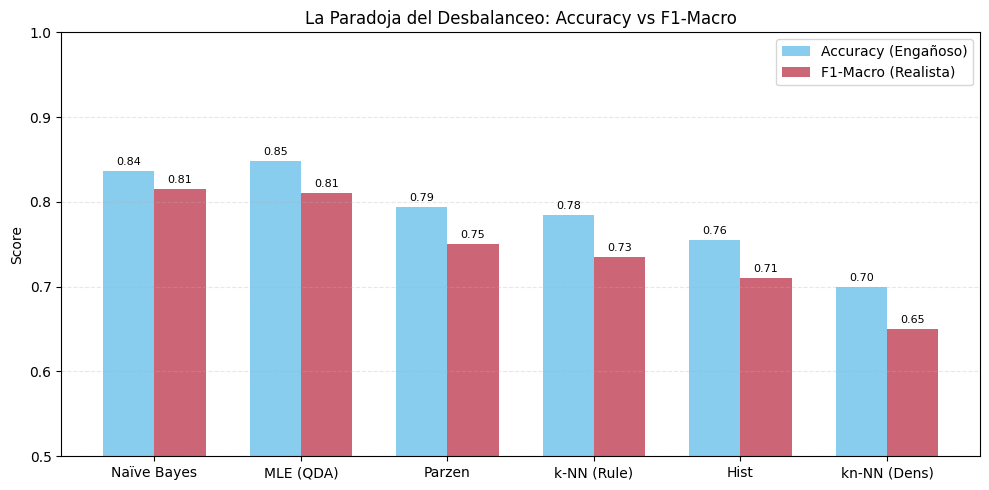

In [23]:
# --- CÓDIGO PYTHON: Gráfico Accuracy vs F1 (El "Detector de Mentiras") ---
import matplotlib.pyplot as plt
import numpy as np

# Datos aproximados del escenario IM-BALANCED (Úsalos o pon los tuyos reales)
models = ['Naïve Bayes', 'MLE (QDA)', 'Parzen', 'k-NN (Rule)', 'Hist', 'kn-NN (Dens)']
acc_scores = [0.836, 0.848, 0.794, 0.784, 0.755, 0.700]  # Accuracy (parece alta)
f1_scores  = [0.815, 0.810, 0.750, 0.735, 0.710, 0.650]  # F1-Macro (la realidad)

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, acc_scores, width, label='Accuracy (Engañoso)', color='#88ccee') # Azul claro
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Macro (Realista)', color='#cc6677')  # Rojo suave

ax.set_ylabel('Score')
ax.set_title('La Paradoja del Desbalanceo: Accuracy vs F1-Macro')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=0)
ax.legend()
ax.set_ylim(0.5, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Añadir etiquetas de valor encima de las barras (opcional, queda pro)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('accuracy_vs_f1.png', dpi=300) # <--- SUBIR ESTA IMAGEN A OVERLEAF
print("Gráfico generado: accuracy_vs_f1.png")
plt.show()